In [ ]:
# python 3.10.12
# !pip install -r requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import json

import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
import seaborn as sns
style.use("fivethirtyeight")
import folium
from folium.plugins import MarkerCluster
from matplotlib.colors import to_hex
from matplotlib import cm

from testes_hipoteses import (teste_t_uma_media, teste_levene, teste_t_amostras_ind, intervalo_confianca, teste_anova,
                              teste_qui_quadrado, teste_normalidade_shapirowilk, teste_kruskal_wallis)

import re
from collections import Counter
from scipy import stats
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

# 1. Introdução

Este notebook faz parte de um projeto mais amplo cujo objetivo é analisar dados de avaliações e estabelecimentos da plataforma Yelp, com foco na identificação de padrões de comportamento dos consumidores, fatores que influenciam a percepção de qualidade e níveis de engajamento dos usuários.

Neste módulo específico, o foco está na **Análise Exploratória de Dados (EDA)** e na **Análise Inferencial**, contemplando desde a preparação e limpeza inicial dos dados até a investigação estatística das relações entre variáveis relevantes do negócio.

As análises conduzidas neste notebook têm como objetivos principais:
- Compreender a distribuição e o comportamento das principais variáveis numéricas e categóricas;
- Identificar padrões de avaliação e engajamento entre diferentes tipos de estabelecimentos;
- Formular e responder perguntas de negócio por meio de análises descritivas, multivariadas e testes estatísticos;
- Gerar hipóteses e insights que fundamentam as etapas posteriores de modelagem.

Os resultados obtidos aqui servem como base para os demais módulos do projeto, incluindo a segmentação de estabelecimentos (clustering), a análise de sentimento das avaliações textuais e a construção de um dashboard interativo para apoio à tomada de decisão.


## Organização do Projeto

O projeto está estruturado de forma modular, com notebooks e componentes que podem ser analisados de maneira independente, garantindo reprodutibilidade e clareza na apresentação dos resultados.

Além deste notebook, o projeto inclui os seguintes módulos:

- **Análise de Clusters**: segmentação dos estabelecimentos com base em métricas de avaliação e engajamento;
- **Classificação Supervisionada**: análise de sentimento das avaliações textuais por meio de modelos de machine learning;
- **Dashboard Interativo**: visualização dos principais insights para apoio à tomada de decisão.

A preparação e limpeza dos dados utilizados nas análises são realizadas neste notebook, como parte do processo exploratório inicial.


**Contexto do Projeto e Dados Utilizados**

Este projeto tem como objetivo analisar dados de avaliações e estabelecimentos da plataforma Yelp, identificando padrões de comportamento dos consumidores e fatores associados ao desempenho dos negócios. A análise combina exploração estatística, inferência e visualização de dados, com foco em responder a perguntas relevantes do ponto de vista empresarial e apoiar a tomada de decisão orientada por dados.

A Yelp é uma plataforma norte-americana de avaliações de estabelecimentos locais, amplamente utilizada para orientar escolhas de consumo. Para este estudo, foi utilizado o dataset público disponibilizado pela empresa para fins educacionais, que reúne informações sobre estabelecimentos, avaliações, utilizadores, check-ins, fotos e elogios [[1]](https://www.yelp-press.com/company/fast-facts/default.aspx).

O escopo da análise foi delimitado ao estado do Tennessee, considerando avaliações realizadas entre 2005 e 2022. Esse recorte permite investigar tendências temporais, padrões de avaliação e características associadas ao desempenho dos estabelecimentos em um contexto regional específico.

O conjunto de dados completo está disponível publicamente pela Yelp [[2]](https://www.yelp.com/dataset), acompanhado de documentação detalhada sobre o esquema das tabelas [[3]](https://www.yelp.com/dataset/documentation/main).

![Diagrama da base de dados](https://raw.githubusercontent.com/ana0212/Yelp---Analise-do-estado-do-Tennessee/main/diagrama.png)

Como o objetivo principal do projeto foi a análise das avaliações e das características dos estabelecimentos, foram utilizadas exclusivamente as tabelas Business e Review. As tabelas Photo, Checkin, Tip e User não foram incluídas por não contribuírem diretamente para as perguntas de negócio definidas.

Inicialmente, considerou-se a inclusão da tabela Tip para investigar possíveis relações entre elogios e avaliações. No entanto, a maioria das observações apresentava valores nulos ou próximos de zero, indicando baixa representatividade estatística e limitado potencial analítico, razão pela qual a tabela foi descartada.

Os dados foram disponibilizados no formato JSON. Como a análise foi restrita ao estado do Tennessee (TN), o processamento iniciou-se pela tabela Business, aplicando-se um filtro geográfico para selecionar apenas os estabelecimentos localizados nesse estado.

Para a tabela Review, devido ao elevado volume de registros, adotou-se uma estratégia de filtragem prévia. Foram extraídos inicialmente os identificadores dos estabelecimentos do Tennessee e, em seguida, o arquivo JSON foi processado linha a linha, armazenando apenas as avaliações associadas a esses estabelecimentos. Essa abordagem permitiu reduzir o consumo de memória e tornar o processamento mais eficiente.

Observação: O código responsável pelo download e filtragem inicial dos dados foi mantido comentado neste notebook, pois os arquivos já filtrados foram previamente salvos em formato .json. Essa abordagem foi adotada para reduzir o consumo de memória e facilitar a execução do notebook em ambientes com recursos limitados, sem comprometer a reprodutibilidade do processo.

In [ ]:
# # Ler o arquivo JSON no formato JSON Lines
# df_business = pd.read_json("yelp_academic_dataset_business.json", lines=True)

# # Filtrar pelo estado do Tennessee
# state = "TN"
# df_business = df_business[df_business["state"] == state]
# df_business = pd.DataFrame(df_business)
# df_business.to_json('df_business_tennessee.json', orient='records', lines=True)
# df_business.info()

In [ ]:
df_business = pd.read_json('df_business_tennessee.json', lines=True)
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12056 entries, 0 to 12055
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   12056 non-null  object 
 1   name          12056 non-null  object 
 2   address       12056 non-null  object 
 3   city          12056 non-null  object 
 4   state         12056 non-null  object 
 5   postal_code   12056 non-null  object 
 6   latitude      12056 non-null  float64
 7   longitude     12056 non-null  float64
 8   stars         12056 non-null  float64
 9   review_count  12056 non-null  int64  
 10  is_open       12056 non-null  int64  
 11  attributes    10996 non-null  object 
 12  categories    12051 non-null  object 
 13  hours         10398 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 1.3+ MB


In [ ]:
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
1,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
2,4iRzR7OaS-QaSXuvYxEGKA,Super Dog,1160 Gallatin Pike S,Nashville,TN,37115,36.248570,-86.719986,4.0,6,0,"{'RestaurantsReservations': 'False', 'Restaura...","Hot Dogs, Restaurants",None
3,tMkwHmWFUEXrC9ZduonpTg,The Green Pheasant,215 1st Ave S,Nashville,TN,37201,36.159886,-86.773197,4.0,161,0,"{'RestaurantsGoodForGroups': 'True', 'HappyHou...","Restaurants, Japanese, Seafood","{'Wednesday': '16:0-22:0', 'Thursday': '16:0-2..."
4,sqSqqLy0sN8n2IZrAbzidQ,Domino's Pizza,3001 Highway 31 W,White House,TN,37188,36.464747,-86.659187,3.5,8,1,{'RestaurantsPriceRange2': '1'},"Pizza, Chicken Wings, Sandwiches, Restaurants","{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ..."


In [ ]:
# Selecionar os ids dos estabelecimentos
business_ids = set(df_business['business_id'].unique())

In [ ]:
# # Caminho do arquivo
# file_path = "yelp_academic_dataset_review.json"

# # Filtrar os reviews enquanto lê o arquivo linha por linha
# filtered_reviews = []

# # Abrir o arquivo e filtrar os registros
# with open(file_path, "r") as f:
#    for line in f:
#        review = json.loads(line)
#        if review['business_id'] in business_ids:
#            filtered_reviews.append(review)

# # Converter a lista filtrada para DataFrame
# df_review = pd.DataFrame(filtered_reviews)
# df_review.to_json('df_review_tennessee.json', orient='records', lines=True)
# df_review.info()

In [ ]:
df_review = pd.read_json('df_review_tennessee.json', lines=True)
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614388 entries, 0 to 614387
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   review_id    614388 non-null  object        
 1   user_id      614388 non-null  object        
 2   business_id  614388 non-null  object        
 3   stars        614388 non-null  int64         
 4   useful       614388 non-null  int64         
 5   funny        614388 non-null  int64         
 6   cool         614388 non-null  int64         
 7   text         614388 non-null  object        
 8   date         614388 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 42.2+ MB


In [ ]:
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,elqRpX9T3YwL07uLNtN3Bg,-sryo4gDYxbZ1T5Bz4l5Bw,ltBBYdNzkeKdCNPDAsxwAA,2,0,0,0,I at least have to give this restaurant two st...,2015-02-02 04:29:13
1,p198qZsKOMCUhgdtRWsOKQ,3MpDvy5gEdsbZh9-p92dHg,8QnuWGVNBhzyYXGSeRdi4g,4,0,0,0,After my ROTD yesterday of a different Sweet ...,2013-10-24 19:24:33
2,E9AB7V4z8xrt2uPF7T55FQ,iYY5Ii1LGpZCpXFkHlMefw,Zx7n8mdt8OzLRXVzolXNhQ,5,0,0,0,Amazing biscuits and (fill in the blank). Grea...,2018-04-27 23:03:21
3,qGQvUHmC02PAZW3H1WTIfw,RRTQpg8hutdimzAYuP_Hbw,eaJCpC6IhYphj7bwCDHTwQ,5,0,0,0,Stopped by after a Sunday morning walk in the ...,2015-08-30 13:41:47
4,67cGcRrS0jTvB8p7rpaPew,8YSxVaD203mE_9FR4nCEVA,oQ5CPRt0R3AzFvcjNOqB1w,3,1,0,0,Honestly the food doesn't knock my socks off b...,2016-01-17 13:26:19


# 2. Limpeza de dados

## 2.1 Tabela Business

**Limpeza e Preparação dos Dados — Tabela Business**

O processo de preparação dos dados da tabela Business iniciou-se pela análise da coluna categories, que apresenta alta cardinalidade e concentra informações relevantes sobre o tipo de estabelecimento. Para padronizar e estruturar essa variável, foi utilizada a lista oficial de categorias e subcategorias da Yelp [[4]](https://blog.yelp.com/businesses/yelp_category_list/), obtida por meio de web scraping.

A partir dessa hierarquia, a coluna original foi decomposta em duas novas variáveis — main_category e subcategories — reduzindo a cardinalidade de 8.596 valores únicos para 445 categorias principais e 4.612 subcategorias. Essa transformação tornou a informação mais organizada e alinhada às práticas de análise de mercado da própria Yelp [[5]](https://trends.yelp.com/2025-yelp-trend-forecast).

A coluna attributes, apesar de conter informações potencialmente relevantes, apresentou alto grau de especificidade e baixa padronização entre categorias. Como o escopo do projeto não se concentrou em um tipo específico de negócio, optou-se por não utilizá-la nesta etapa da análise [[6]](https://blog.yelp.com/businesses/the-most-popular-business-attributes-on-yelp-in-2024/).

Em seguida, foi realizado o tratamento da coluna hours, incluindo a extração das informações do dicionário e a criação da variável total_hours, que representa o total de horas semanais de funcionamento dos estabelecimentos. Foram identificados valores ausentes nessa variável, os quais foram registrados para possível tratamento em etapas futuras de modelagem.

Por fim, a coluna city foi padronizada por meio de normalização textual (lowercase e remoção de inconsistências). Essa mesma estratégia de pré-processamento foi aplicada posteriormente à coluna text da tabela Review.

Verificações adicionais de consistência entre as tabelas foram realizadas para assegurar a integridade dos dados analisados. Como não resultaram em alterações no dataset final, o código correspondente foi removido desta seção.

In [ ]:
# Verificar valores únicos da coluna 'categories'
df_business['categories'].value_counts()

,count
categories,
"Mexican, Restaurants",90
"Restaurants, Mexican",87
"Beauty & Spas, Nail Salons",81
"Nail Salons, Beauty & Spas",76
"Hotels, Hotels & Travel, Event Planning & Services",49
...,...
"Event Planning & Services, Caterers, Chicken Shop, Restaurants, Fast Food",1
"Burgers, Fish & Chips, Soul Food, Chicken Wings, Restaurants",1
"Specialty Food, Food, Candy Stores, Chocolatiers & Shops",1


In [ ]:
# # URL da página oficial de categorias
# url = "https://blog.yelp.com/businesses/yelp_category_list/"

# # Cabeçalho com User-Agent
# headers = {
#     "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36"
# }

# # Fazer a requisição HTTP
# response = requests.get(url, headers=headers)
# response.raise_for_status()

# # Parser o HTML
# soup = BeautifulSoup(response.text, 'html.parser')

# # Dicionário para armazenar categorias e subcategorias
# categories = []

# # Encontrar todas as categorias principais
# accordion_rows = soup.find_all('article', class_='c-accordion__row')

# for row in accordion_rows:
#     # Encontrar o nome da categoria principal
#     main_category = row.find('button', class_='c-accordion__header').text.strip()

#     # Encontrar subcategorias associadas
#     subcategory_list = row.find('ul')
#     if subcategory_list:
#         subcategories = [li.text.strip() for li in subcategory_list.find_all('li')]
#     else:
#         subcategories = []

#     # Adicionar ao dicionário
#     for subcategory in subcategories:
#         categories.append({'Main Category': main_category, 'Subcategory': subcategory})

# # Converter em DataFrame
# df_categories = pd.DataFrame(categories)

# # Salvar em CSV
# df_categories.to_csv('yelp_categories.csv', index=False)

# # Visualizar os primeiros resultados
# print(df_categories.head())

In [ ]:
df_categories = pd.read_csv('yelp_categories.csv')
df_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526 entries, 0 to 1525
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Main Category  1526 non-null   object
 1   Subcategory    1526 non-null   object
dtypes: object(2)
memory usage: 24.0+ KB


In [ ]:
# Criação de um dicionário Main Category → Subcategorias
subcategory_map = df_categories.set_index('Subcategory')['Main Category'].to_dict()

# Função para obter a main category com base nas categorias
def extract_categories(row, mapping):
    if not isinstance(row, str):
        return ""  # Retornar vazio para categorias ausentes
    categories = row.split(", ")
    main_categories = set()
    subcategories = set()

    for category in categories:
        if category in subcategory_map:
            # Se é uma subcategoria, adiciona a main category correspondente e a subcategoria
            main_categories.add(subcategory_map[category])
            subcategories.add(category)
        elif category in subcategory_map.values():
            # Se é uma main category, adiciona diretamente
            main_categories.add(category)

    # Transformar conjuntos em listas ordenadas e retornar como string
    main_category = ", ".join(sorted(main_categories))
    subcategory = ", ".join(sorted(subcategories))
    return main_category, subcategory

# Aplicar a função para cada linha no dataframe
df_business[['main_category', 'subcategories']] = df_business['categories'].apply(
    lambda x: pd.Series(extract_categories(x, subcategory_map))
)

# Verificar o resultado
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12056 entries, 0 to 12055
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   business_id    12056 non-null  object 
 1   name           12056 non-null  object 
 2   address        12056 non-null  object 
 3   city           12056 non-null  object 
 4   state          12056 non-null  object 
 5   postal_code    12056 non-null  object 
 6   latitude       12056 non-null  float64
 7   longitude      12056 non-null  float64
 8   stars          12056 non-null  float64
 9   review_count   12056 non-null  int64  
 10  is_open        12056 non-null  int64  
 11  attributes     10996 non-null  object 
 12  categories     12051 non-null  object 
 13  hours          10398 non-null  object 
 14  main_category  12056 non-null  object 
 15  subcategories  12051 non-null  object 
dtypes: float64(3), int64(2), object(11)
memory usage: 1.5+ MB


In [ ]:
# Verificar valores únicos da coluna 'main_category'
df_business.main_category.value_counts()

,count
main_category,
Restaurants,2277
"Food, Restaurants",930
Shopping,751
Beauty & Spas,736
Automotive,641
...,...
"Health & Medical, Home Services",1
"Food, Local Services, Shopping",1
"Hotels & Travel, Local Services, Nightlife",1


In [ ]:
# Verificar valores únicos da coluna 'subcategories'
df_business.subcategories.value_counts()

,count
subcategories,
,1082
Apartments,191
Nail Salons,166
Pizza,130
Coffee & Tea,112
...,...
"Orthopedists, Physical Therapy, Sports Medicine",1
"Desserts, Salad, Tacos",1
"Arcades, Bowling, Go Karts, Pizza",1


In [ ]:
# Função para tratar colunas datetime
def analyze_business_hours(hours_dict):

    if not isinstance(hours_dict, dict):
        return {
            'days_open': 0,
            'total_hours': 0.0
        }

    days_open = 0
    total_hours = 0.0

    for day, time_range in hours_dict.items():
        if time_range:
            days_open += 1

            # Extrair horários de abertura e fechamento
            opening_time, closing_time = time_range.split('-')
            opening_time = datetime.strptime(opening_time, "%H:%M").time()
            closing_time = datetime.strptime(closing_time, "%H:%M").time()

            # Calcular as horas abertas no dia
            base_date = datetime(1900, 1, 1)
            opening_datetime = datetime.combine(base_date, opening_time)
            closing_datetime = datetime.combine(base_date, closing_time)

            # Considerar horário que passa da meia-noite
            if closing_datetime < opening_datetime:
                closing_datetime += timedelta(days=1)

            total_hours += (closing_datetime - opening_datetime).seconds / 3600.0

    return {
        'days_open': days_open,
        'total_hours': total_hours
    }


# Substituir valores nulos na coluna 'hours' por {} (dicionário vazio)
df_business['hours'] = df_business['hours'].fillna({})

df_business['analysis'] = df_business['hours'].apply(analyze_business_hours)

# Separar os resultados em colunas distintas
df_business['total_hours'] = df_business['analysis'].apply(lambda x: x['total_hours'])

df_business[['hours', 'total_hours']].head()

,hours,total_hours
0,"{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",90.0
1,"{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",76.0
2,None,0.0
3,"{'Wednesday': '16:0-22:0', 'Thursday': '16:0-2...",26.0
4,"{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ...",100.0


## 2.2 Tabela Review

**Limpeza e Preparação dos Dados — Tabela Review**

O processamento da tabela Review iniciou-se com o tratamento da variável temporal date, a partir da qual foram extraídas informações adicionais para enriquecer a análise exploratória. Foram derivadas as seguintes variáveis: weekday, is_weekend, month, year, hour e time_of_day.

Após a análise exploratória inicial, optou-se por manter apenas as variáveis consideradas mais relevantes para os objetivos do projeto:
- year: utilizada para analisar a evolução das avaliações ao longo do tempo e identificar tendências temporais;
- time_of_day: permite investigar padrões de comportamento relacionados ao período do dia em que as avaliações são realizadas;
- is_weekend: possibilita comparar diferenças de comportamento entre dias úteis e fins de semana.

As demais variáveis temporais extraídas não foram utilizadas nas análises subsequentes por não agregarem valor significativo ao escopo definido.

Em seguida, foi realizado o pré-processamento da coluna text, aplicando-se a mesma função de limpeza textual utilizada na coluna city da tabela Business. Esse processo incluiu padronização para letras minúsculas, tokenização, remoção de pontuação e stopwords, além da aplicação de stemming. O objetivo foi preparar o texto das avaliações para análises posteriores, garantindo consistência e qualidade nos dados textuais.

In [ ]:
# Função para tratar colunas datetime
def process_datetime_features(df, datetime_column):

    # Converter para datetime se ainda não estiver
    df[datetime_column] = pd.to_datetime(df[datetime_column])

    # Extrair dia da semana (0 = Segunda, 6 = Domingo)
    df['weekday'] = df[datetime_column].dt.dayofweek

    # Final de semana (True para sábado e domingo)
    df['is_weekend'] = df['weekday'].isin([5, 6])

    # Extrair mês
    df['month'] = df[datetime_column].dt.month

    # Extrair ano
    df['year'] = df[datetime_column].dt.year

    # Extrair hora
    df['hour'] = df[datetime_column].dt.hour

    # Categorizar período do dia
    def categorize_time(hour):
        if 5 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 17:
            return 'afternoon'
        elif 17 <= hour < 21:
            return 'evening'
        else:
            return 'night'
    df['time_of_day'] = df['hour'].apply(categorize_time)

    return df

In [ ]:
# Processando o DataFrame de reviews
df_review = process_datetime_features(df_review, 'date')

In [ ]:
# Baixar stopwords da biblioteca NLTK
nltk.download('stopwords')

# Carregar stopwords do NLTK
stop_words = set(stopwords.words('english'))

# Aplicar o Tokenizer
tokenizer = WordPunctTokenizer()

# Aplicar o stemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

# Função para limpar colunas de texto
def clean_text(doc):
    # Transformar em lowercase
    doc = doc.lower()

    # Tokenizar o texto
    words = tokenizer.tokenize(doc)

    # Remover pontuação e stopwords
    words = [word for word in words if word not in string.punctuation and word not in stop_words]

    # Aplicar stemming
    stems = [stemmer.stem(word) for word in words]

    # Reunir as palavras em uma string
    clean_text = " ".join(stems)

    return clean_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Aplicando a função para tratamento das variáveis de texto
df_review['cleaned_text'] = df_review['text'].apply(clean_text)
df_business['cleaned_city'] = df_business['city'].apply(clean_text)

In [ ]:
# Salvar dados limpos
df_business.to_json('df_business_tennessee_cleaned.json', orient='records', lines=True)

In [ ]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614388 entries, 0 to 614387
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   review_id     614388 non-null  object        
 1   user_id       614388 non-null  object        
 2   business_id   614388 non-null  object        
 3   stars         614388 non-null  int64         
 4   useful        614388 non-null  int64         
 5   funny         614388 non-null  int64         
 6   cool          614388 non-null  int64         
 7   text          614388 non-null  object        
 8   date          614388 non-null  datetime64[ns]
 9   weekday       614388 non-null  int32         
 10  is_weekend    614388 non-null  bool          
 11  month         614388 non-null  int32         
 12  year          614388 non-null  int32         
 13  hour          614388 non-null  int32         
 14  time_of_day   614388 non-null  object        
 15  cleaned_text  614

In [ ]:
# Salvar dados limpos
df_review.to_json('df_review_tennessee_cleaned.json', orient='records', lines=True)

# 3. Análise Exploratória


Esta seção tem como objetivo explorar e compreender a estrutura, a distribuição e os principais padrões presentes nos dados de avaliações e estabelecimentos da plataforma Yelp. A Análise Exploratória de Dados (EDA) é uma etapa fundamental do processo analítico, pois permite identificar tendências, relações entre variáveis, possíveis inconsistências e hipóteses relevantes para o negócio antes da aplicação de modelos mais avançados.

Inicialmente, é realizada uma análise descritiva, composta por abordagens univariadas e multivariadas, com o intuito de caracterizar as variáveis individualmente e investigar associações entre diferentes dimensões dos dados, como avaliações, categorias de estabelecimentos e fatores temporais.

Em seguida, a análise inferencial complementa a exploração descritiva por meio da aplicação de testes estatísticos, permitindo avaliar relações significativas entre variáveis e validar hipóteses levantadas durante a EDA. Esses resultados contribuem para a geração de insights acionáveis e para o suporte à tomada de decisão baseada em dados.

## 3.1 Análise Descritiva

Esta seção tem como objetivo explorar os dados de forma sistemática, identificando padrões, distribuições, outliers e possíveis relações entre variáveis. A análise descritiva serve como base para a formulação de perguntas de negócio e hipóteses que serão aprofundadas nas análises multivariada e inferencial.

### 3.1.1 Univariada

A análise univariada foi conduzida separadamente para as tabelas Business e Review, com foco em compreender o comportamento individual de cada variável relevante.

**Tabela Business**

Para as variáveis numéricas (stars, review_count e total_hours), foram analisadas estatísticas descritivas e distribuições, com atenção especial à presença de outliers, principalmente na variável review_count, que apresenta alta dispersão.

Para as variáveis categóricas (cleaned_city e main_category), foram construídos gráficos de barras com as 10 categorias mais frequentes, permitindo identificar os principais tipos de estabelecimentos e cidades mais representadas no dataset.

**Tabela Review**

As variáveis numéricas (stars, useful, funny e cool e year) foram analisadas por meio de estatísticas descritivas e visualizações para compreender a distribuição das avaliações ao longo do tempo e o padrão de engajamento dos utilizadores.

As variáveis categóricas (is_weekend e time_of_day) foram exploradas por meio de gráficos de frequência, permitindo observar diferenças no comportamento dos utilizadores conforme o período do dia e o tipo de dia.

Também foi realizada a análise da frequência das palavras mais utilizadas nos textos das avaliações, com o objetivo de identificar termos recorrentes e temas dominantes no feedback dos consumidores.

In [ ]:
# Dados descritivos das variáveis numéricas
df_business_num = ['stars', 'review_count', 'total_hours']
df_business[df_business_num].describe()

,stars,review_count,total_hours
count,12056.000000,12056.000000,12056.000000
mean,3.571500,49.618033,48.651555
std,0.996775,142.306695,31.712945
min,1.000000,5.000000,0.000000
25%,3.000000,8.000000,30.000000
50%,3.500000,16.000000,51.000000
75%,4.500000,40.000000,70.000000
max,5.000000,6093.000000,167.883333


In [ ]:
# Calculando IQR
Q1 = df_business['review_count'].quantile(0.25)
Q3 = df_business['review_count'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

# Identificando outliers
review_count_outliers = df_business[(df_business['review_count'] < (Q1 - 1.5*IQR)) | (df_business['review_count'] > (Q3 + 1.5*IQR))]
print(review_count_outliers.info())

32.0
<class 'pandas.core.frame.DataFrame'>
Index: 1432 entries, 3 to 12054
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   business_id    1432 non-null   object 
 1   name           1432 non-null   object 
 2   address        1432 non-null   object 
 3   city           1432 non-null   object 
 4   state          1432 non-null   object 
 5   postal_code    1432 non-null   object 
 6   latitude       1432 non-null   float64
 7   longitude      1432 non-null   float64
 8   stars          1432 non-null   float64
 9   review_count   1432 non-null   int64  
 10  is_open        1432 non-null   int64  
 11  attributes     1427 non-null   object 
 12  categories     1432 non-null   object 
 13  hours          1397 non-null   object 
 14  main_category  1432 non-null   object 
 15  subcategories  1432 non-null   object 
 16  analysis       1432 non-null   object 
 17  total_hours    1432 non-null   float64
 18  cleaned

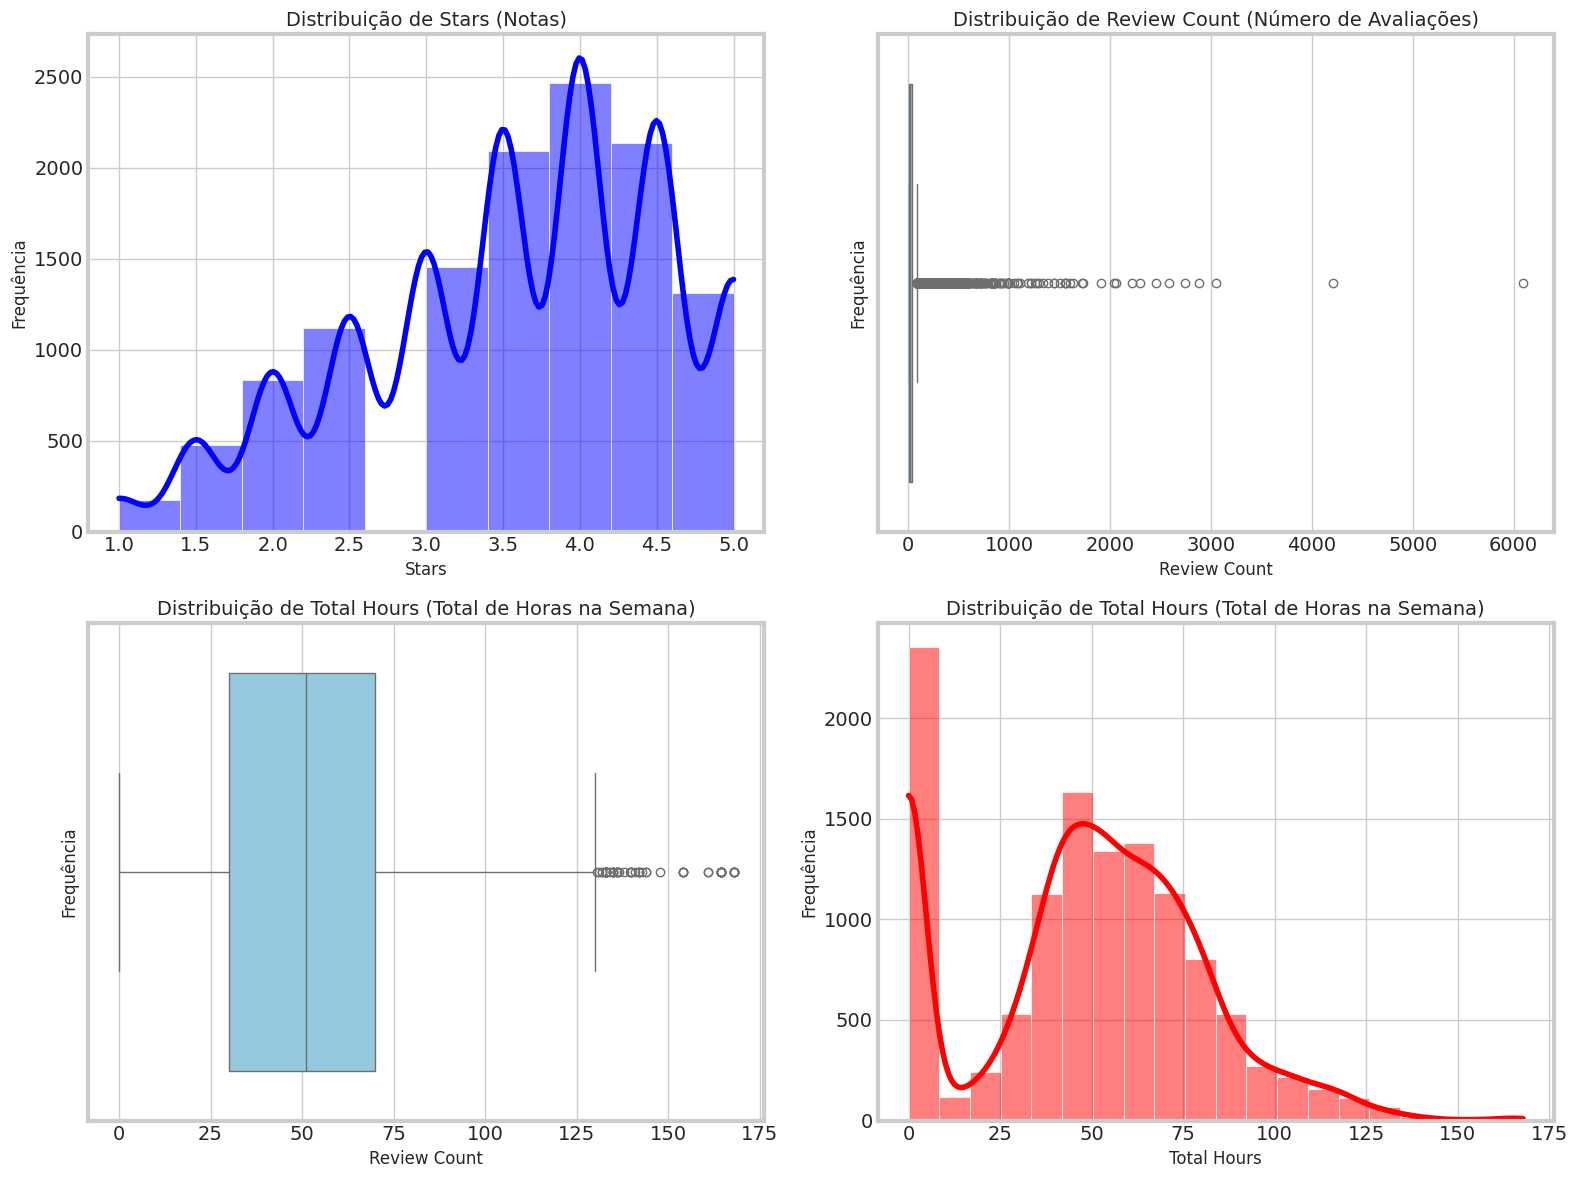

In [ ]:
# Ajuste de estilo para os gráficos
sns.set_style("whitegrid")
plt.figure(figsize=(16, 12))

# Stars
plt.subplot(2, 2, 1)
sns.histplot(df_business['stars'], bins=10, kde=True, color='blue')
plt.title('Distribuição de Stars (Notas)', fontsize=14)
plt.xlabel('Stars', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Review_count
plt.subplot(2, 2, 2)
sns.boxplot(x=df_business['review_count'], color='skyblue')
plt.title('Distribuição de Review Count (Número de Avaliações)', fontsize=14)
plt.xlabel('Review Count', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Review_count
plt.subplot(2, 2, 3)
sns.boxplot(x=df_business['total_hours'], color='skyblue')
plt.title('Distribuição de Total Hours (Total de Horas na Semana)', fontsize=14)
plt.xlabel('Review Count', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Total_hours
plt.subplot(2, 2, 4)
sns.histplot(df_business['total_hours'], bins=20, kde=True, color='red')
plt.title('Distribuição de Total Hours (Total de Horas na Semana)', fontsize=14)
plt.xlabel('Total Hours', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Ajuste o layout para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()

**Principais Destaques — Tabela Business (Variáveis Numéricas)**
- Stars: A média das avaliações é 3,57, com desvio padrão de 0,99, indicando concentração em torno da média. O terceiro quartil em 4,5 sugere que 25% dos estabelecimentos possuem avaliações muito altas. De forma geral, a maioria das avaliações é positiva (acima de 2,5 estrelas).
- Review_count: A média é 49,6, porém com desvio padrão elevado (142,3), evidenciando forte assimetria à direita. A mediana de 16 indica que a maior parte dos estabelecimentos possui poucas avaliações, enquanto cerca de 12% dos registros são outliers, representando negócios com alta visibilidade ou engajamento.
- Total_hours (horas semanais de funcionamento): A média é 48,65 horas, compatível com um funcionamento típico de aproximadamente 8 horas por dia em 6 dias da semana. A elevada variabilidade (desvio padrão de 31,71) e valores máximos de até 167,88 horas sugerem a presença de outliers ou estabelecimentos com operação contínua (24/7).

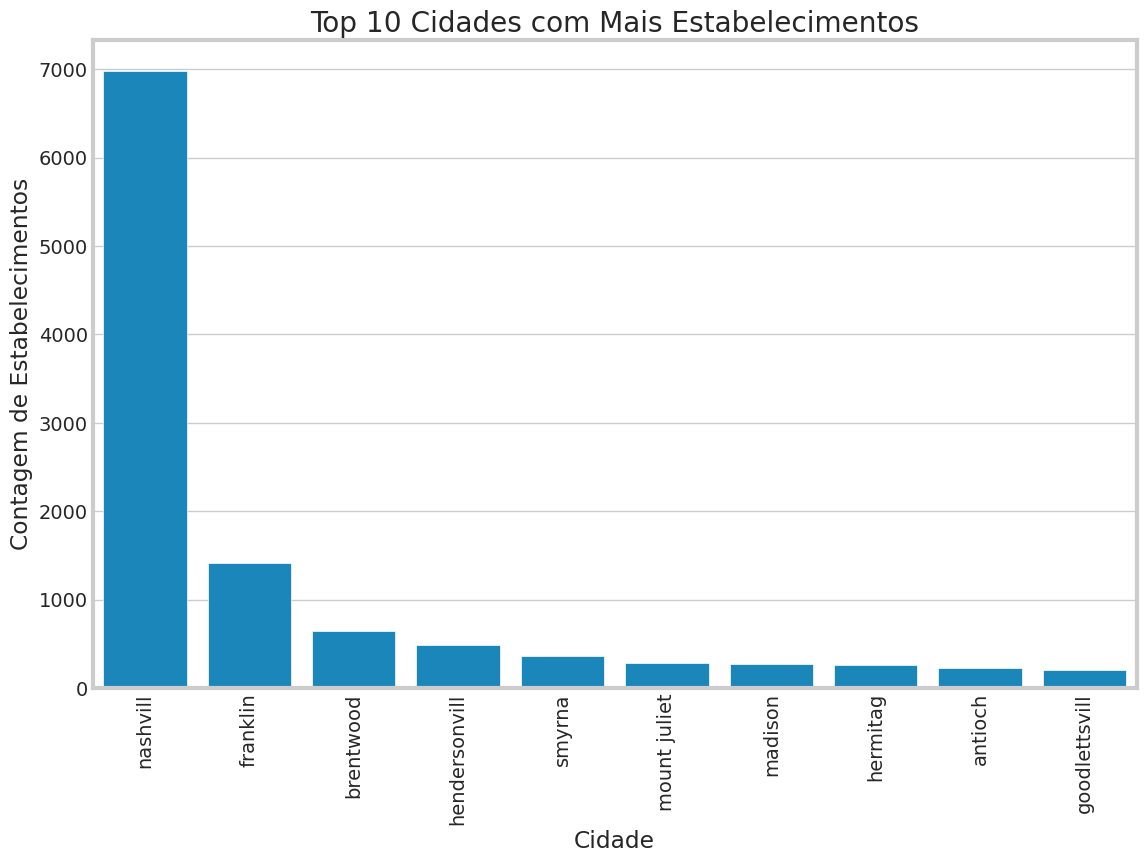

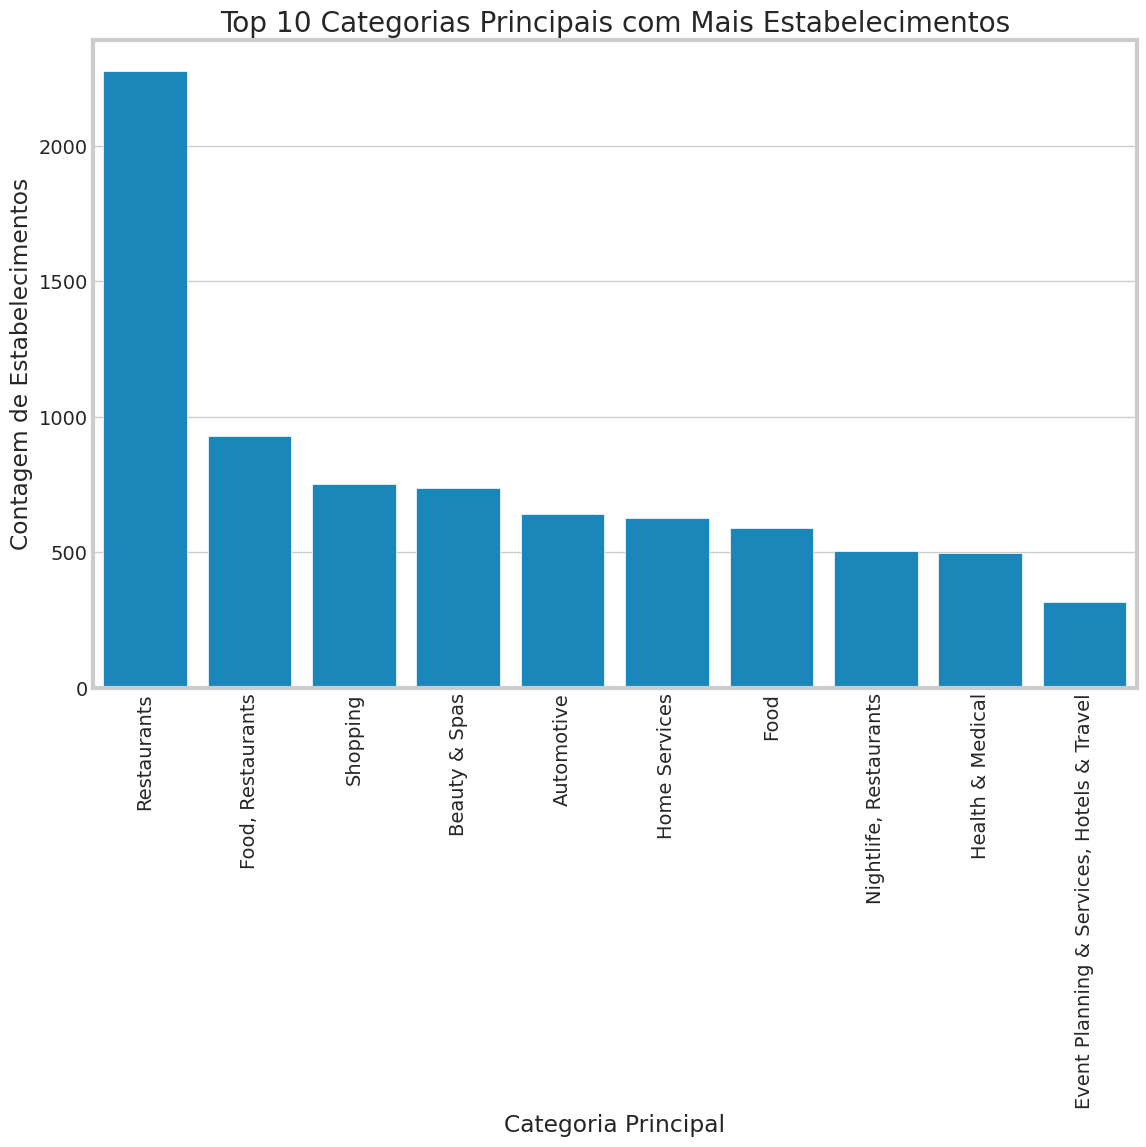

In [ ]:
# Cleaned_city
top_cities = df_business['cleaned_city'].value_counts().nlargest(10)

plt.figure(figsize=(12, 8))
sns.countplot(data=df_business[df_business['cleaned_city'].isin(top_cities.index)], x='cleaned_city', order=top_cities.index)
plt.title('Top 10 Cidades com Mais Estabelecimentos')
plt.xticks(rotation=90)
plt.xlabel('Cidade')
plt.ylabel('Contagem de Estabelecimentos')
plt.show()

# Main_category
top_main_categories = df_business['main_category'].value_counts().nlargest(10)

plt.figure(figsize=(12, 8))
sns.countplot(data=df_business[df_business['main_category'].isin(top_main_categories.index)], x='main_category', order=top_main_categories.index)
plt.title('Top 10 Categorias Principais com Mais Estabelecimentos')
plt.xticks(rotation=90)
plt.xlabel('Categoria Principal')
plt.ylabel('Contagem de Estabelecimentos')
plt.show()

**Principais Destaques — Tabela Business (Variáveis Categóricas)**

- Observa-se alta concentração de estabelecimentos na cidade de Nashville, capital do estado, indicando um polo significativo de atividade econômica local.
- As categorias mais frequentes estão fortemente associadas ao setor de alimentação e entretenimento, com destaque para Restaurants, Food e Nightlife, que representam quatro das dez principais categorias.
- Essa concentração geográfica e setorial sugere oportunidades estratégicas para ações de marketing e análise de mercado voltadas especialmente ao setor de alimentação e lazer na região metropolitana de Nashville.

In [ ]:
# Dados descritivos das variáveis numéricas
df_review_num = ['stars', 'useful', 'funny', 'cool', 'year']
df_review[df_review_num].describe()

,stars,useful,funny,cool,year
count,614388.000000,614388.000000,614388.000000,614388.000000,614388.000000
mean,3.760418,0.913973,0.270804,0.385950,2016.852663
std,1.478794,2.901106,1.275611,1.740239,2.971344
min,1.000000,-1.000000,0.000000,0.000000,2005.000000
25%,3.000000,0.000000,0.000000,0.000000,2015.000000
50%,4.000000,0.000000,0.000000,0.000000,2017.000000
75%,5.000000,1.000000,0.000000,0.000000,2019.000000
max,5.000000,539.000000,254.000000,304.000000,2022.000000


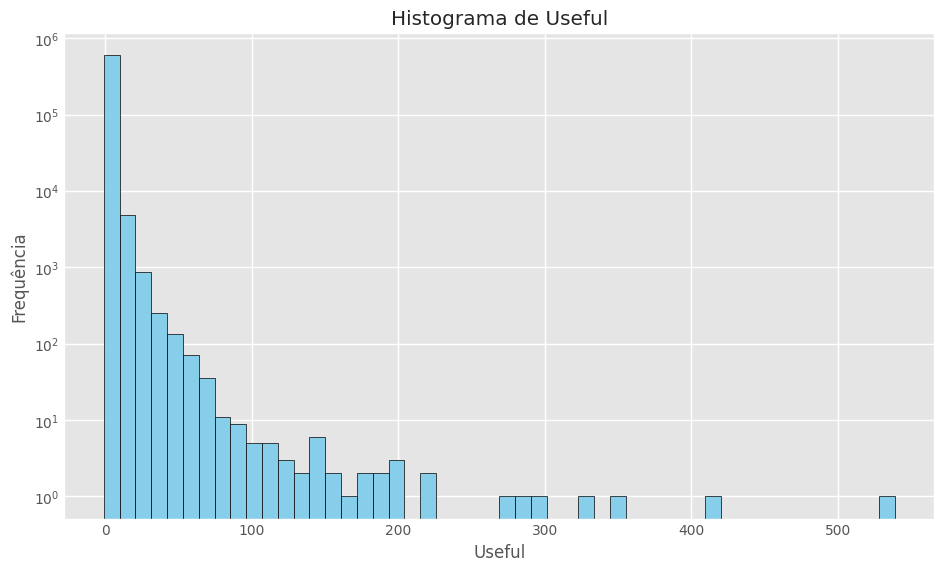

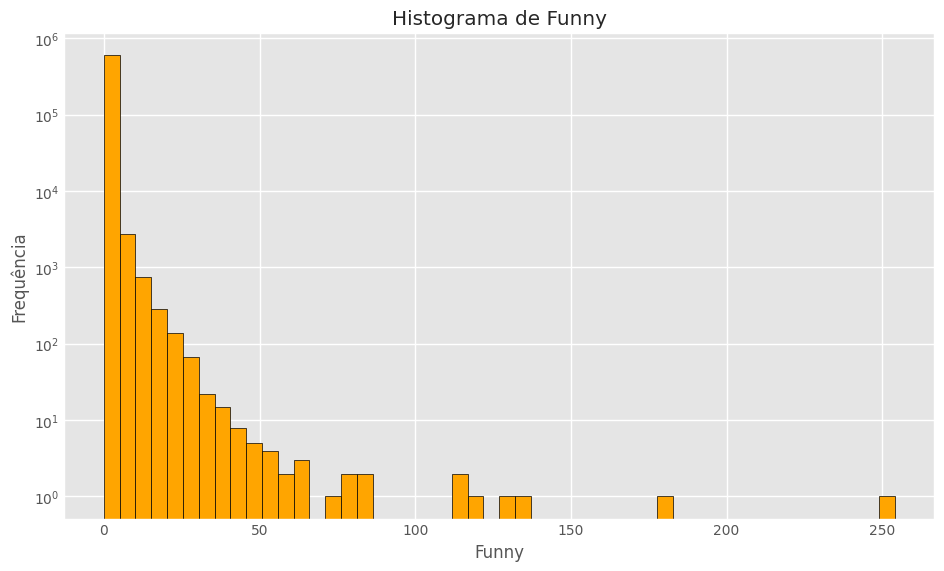

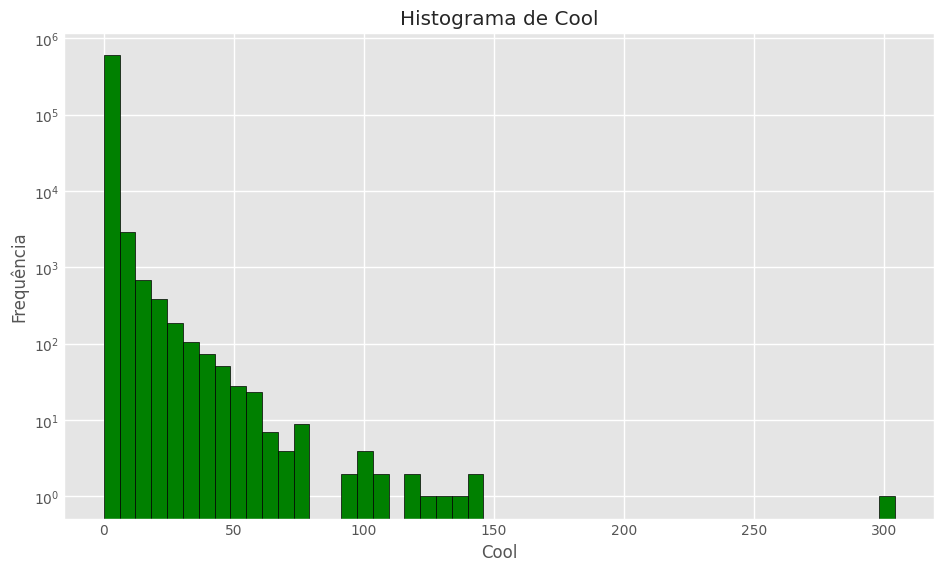

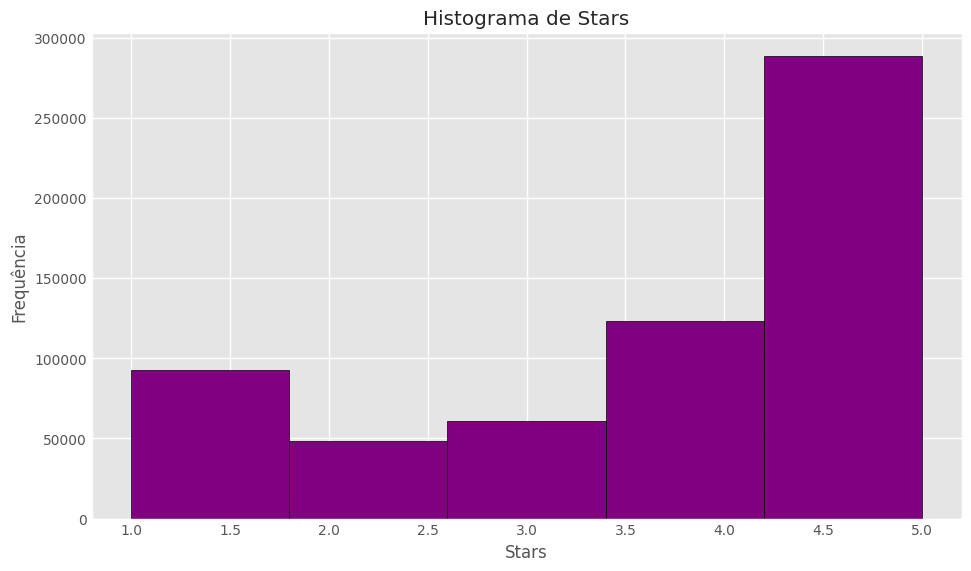

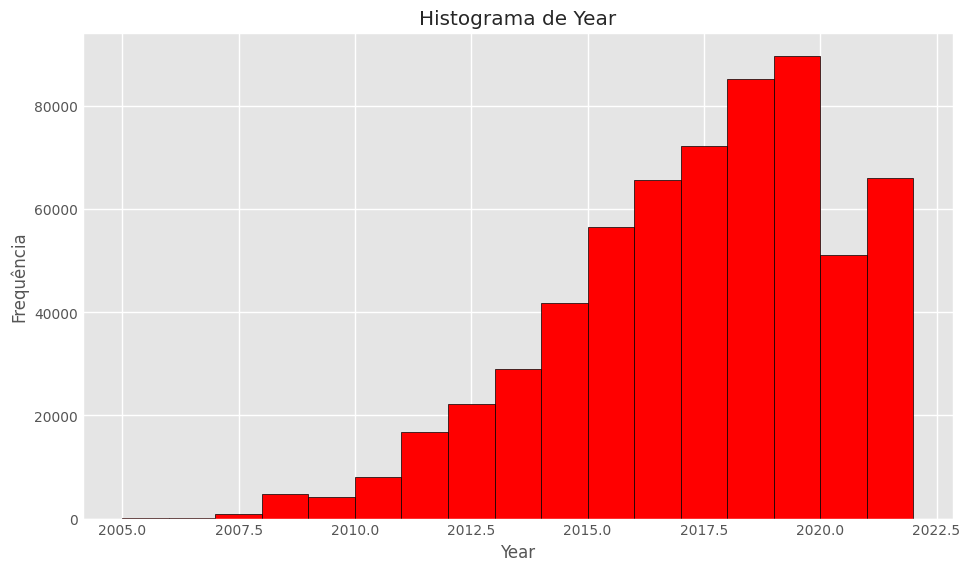

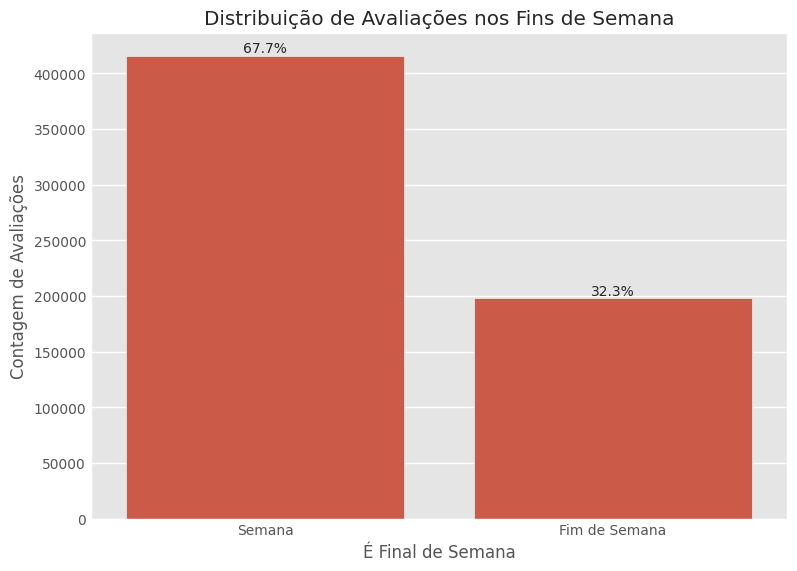

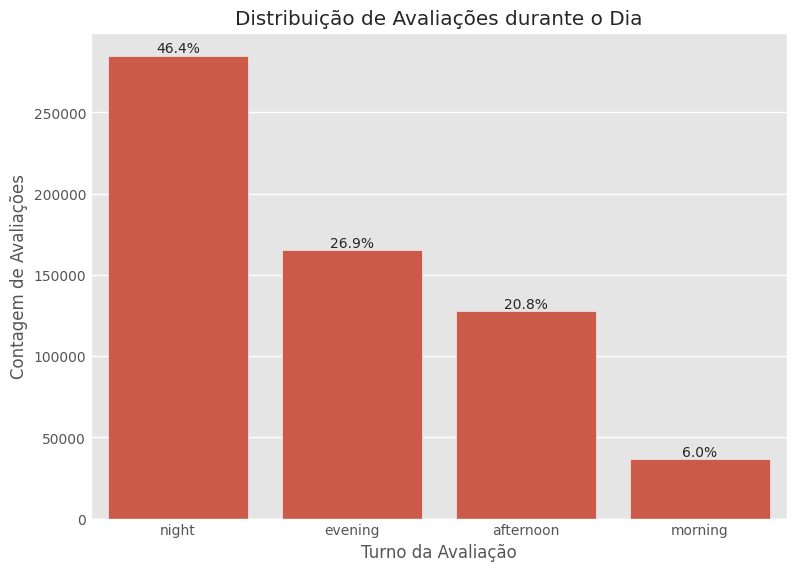

In [ ]:
# Configurações gerais para os gráficos
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

# Histograma para useful
plt.figure()
plt.hist(df_review['useful'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma de Useful')
plt.xlabel('Useful')
plt.ylabel('Frequência')
plt.yscale('log')  # Escala logarítmica devido aos outliers
plt.show()

# Histograma para funny
plt.figure()
plt.hist(df_review['funny'], bins=50, color='orange', edgecolor='black')
plt.title('Histograma de Funny')
plt.xlabel('Funny')
plt.ylabel('Frequência')
plt.yscale('log')  # Escala logarítmica devido aos outliers
plt.show()

# Histograma para cool
plt.figure()
plt.hist(df_review['cool'], bins=50, color='green', edgecolor='black')
plt.title('Histograma de Cool')
plt.xlabel('Cool')
plt.ylabel('Frequência')
plt.yscale('log')  # Escala logarítmica devido aos outliers
plt.show()

# Histograma para stars
plt.figure()
plt.hist(df_review['stars'], bins=5, color='purple', edgecolor='black')
plt.title('Histograma de Stars')
plt.xlabel('Stars')
plt.ylabel('Frequência')
plt.show()

# Histograma para year
plt.figure()
plt.hist(df_review['year'], bins=range(int(df_review['year'].min()), int(df_review['year'].max()) + 1), color='red', edgecolor='black')
plt.title('Histograma de Year')
plt.xlabel('Year')
plt.ylabel('Frequência')
plt.show()

# Gráfico de barras para 'is_weekend' com porcentagens
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_review, x='is_weekend')
plt.title('Distribuição de Avaliações nos Fins de Semana')
plt.xlabel('É Final de Semana')
plt.ylabel('Contagem de Avaliações')
plt.xticks([0, 1], ['Semana', 'Fim de Semana'])  # Renomeando os valores do eixo x

# Adicionar porcentagens
total = len(df_review)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 10, f'{percentage:.1f}%', ha='center', va='bottom')

plt.show()

# Gráfico de barras para 'time_of_day' com porcentagens
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_review, x='time_of_day')
plt.title('Distribuição de Avaliações durante o Dia')
plt.xlabel('Turno da Avaliação')
plt.ylabel('Contagem de Avaliações')

# Adicionar porcentagens
total = len(df_review)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 10, f'{percentage:.1f}%', ha='center', va='bottom')

plt.show()

/tmp/ipython-input-4072895448.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Word', x='Count', data=df_common_words, palette=sns.light_palette("#d32323", n_colors=40, reverse=True))
/tmp/ipython-input-4072895448.py:21: UserWarning: The palette list has more values (40) than needed (20), which may not be intended.
  sns.barplot(y='Word', x='Count', data=df_common_words, palette=sns.light_palette("#d32323", n_colors=40, reverse=True))


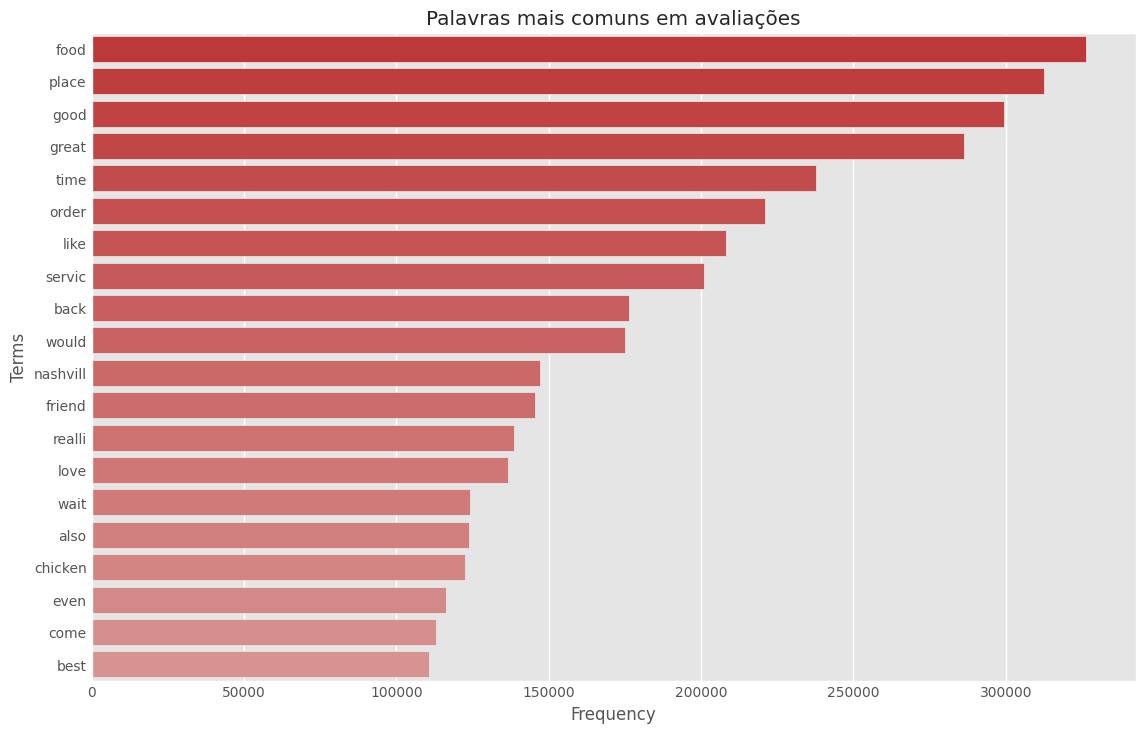

In [ ]:
# Contar as palavras mais comuns
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_review['cleaned_text'].dropna())

# Somar as ocorrências de cada palavra
word_counts = np.asarray(X.sum(axis=0)).flatten()
word_freq = Counter(dict(zip(vectorizer.get_feature_names_out(), word_counts)))

# Filtrar apenas palavras com mais de 3 letras
filtered_word_freq = {word: count for word, count in word_freq.items() if len(word) > 3}

# Selecionar as 20 palavras mais comuns
common_words = Counter(filtered_word_freq).most_common(20)
words, counts = zip(*common_words)

# Criar DataFrame para facilitar a plotagem com Seaborn
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Gráfico de barras dos termos mais comuns com gradiente de cor
plt.figure(figsize=(12, 8))
sns.barplot(y='Word', x='Count', data=df_common_words, palette=sns.light_palette("#d32323", n_colors=40, reverse=True))
plt.title('Palavras mais comuns em avaliações')
plt.xlabel('Frequency')
plt.ylabel('Terms')
plt.show()

**Principais Destaques — Tabela Review**

- Stars: A média é 3,76, valor ligeiramente superior ao observado na tabela Business, o que é esperado, dado que esta última representa a média agregada das avaliações por estabelecimento.
- Useful, Funny e Cool: As médias são baixas (0,91, 0,27 e 0,38, respectivamente), com mediana igual a zero, indicando que a maioria das avaliações não recebe votos de reação. No entanto, os elevados valores máximos (até 539 votos em useful) e altos desvios padrão apontam que um subconjunto reduzido de avaliações gera impacto significativo.
- Year: A distribuição apresenta cauda à esquerda, com registros desde 2005, mas primeiro quartil em 2015, sugerindo crescimento expressivo da plataforma a partir desse período. Esse padrão pode refletir a expansão da Yelp, aumento da base de usuários e maior adoção da plataforma por negócios locais.
- Final de semana: Aproximadamente 67,7% das avaliações foram realizadas em dias úteis, indicando maior atividade de avaliação durante a semana.
- Período do dia: Quase 46,4% das avaliações ocorrem no período noturno, possivelmente associado a experiências de consumo como jantares, lazer e eventos sociais, que tendem a gerar maior engajamento dos usuários.

Análise textual — palavras mais frequentes:
- Termos como food, place, service e good/great indicam foco recorrente na qualidade da comida, do atendimento e da experiência geral.
- Palavras como nashvill, friend e back sugerem forte contextualização local e menções a experiências sociais.
- A presença de wait e order destaca o tempo de espera e o processo de pedido como fatores relevantes na percepção do cliente.
- Expressões como love e really reforçam o caráter emocional das avaliações, evidenciando forte envolvimento dos usuários com determinados estabelecimentos.

### 3.1.2 Multivariada

Esta seção tem como objetivo investigar as relações entre múltiplas variáveis, buscando identificar padrões relevantes e responder a perguntas de negócio a partir da combinação de informações das tabelas Business e Review.

**Pergunta 1: Há alguma categoria de negócio que se destaque em relação à média das avaliações (stars)?**

Para responder a esta questão, foi construído um gráfico considerando as 10 categorias mais populares, comparando suas médias de estrelas com a média geral do dataset (3.5).

/tmp/ipython-input-3574744595.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_stars_by_top_category, x='stars', y='main_category', palette="viridis")


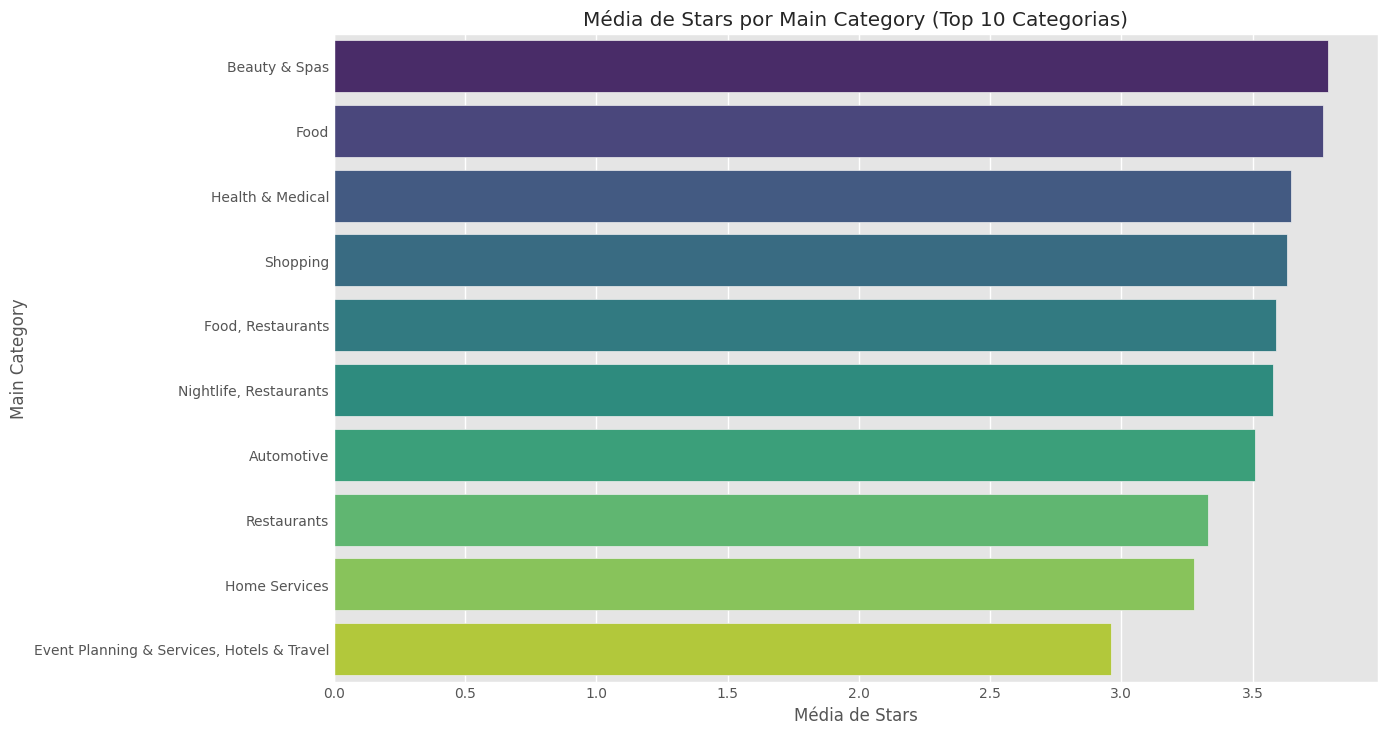

In [ ]:
# Selecionar as 10 categorias mais comuns
top_10_categories = df_business['main_category'].value_counts().head(10).index
df_top_categories = df_business[df_business['main_category'].isin(top_10_categories)]

# Gráfico de barras: Média de estrelas por categoria principal (Top 10 categorias)
mean_stars_by_top_category = df_top_categories.groupby('main_category')['stars'].mean().reset_index()
mean_stars_by_top_category = mean_stars_by_top_category.sort_values(by='stars', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=mean_stars_by_top_category, x='stars', y='main_category', palette="viridis")
plt.title('Média de Stars por Main Category (Top 10 Categorias)')
plt.xlabel('Média de Stars')
plt.ylabel('Main Category')
plt.show()

Os resultados indicam que as categorias Beauty & Spas e Food apresentam médias de avaliação superiores à média global, sugerindo maior satisfação dos consumidores nesses segmentos. Esse comportamento pode refletir expectativas mais bem atendidas ou experiências mais consistentes nesses tipos de negócio.

**Pergunta 2: Qual a relação entre a média das estrelas (stars) e o número de avaliações (review_count)?**


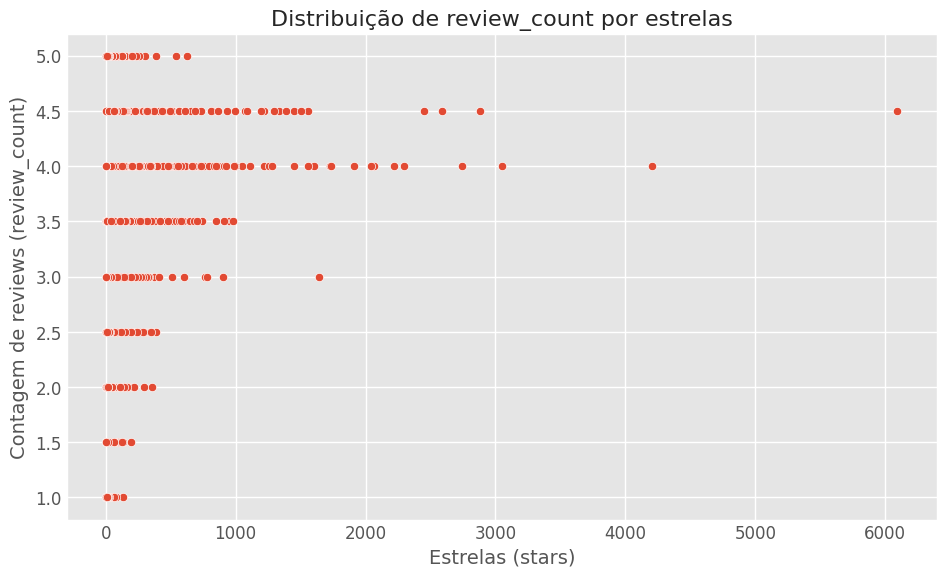

In [ ]:
# Gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_count', y='stars', data=df_business)

plt.title('Distribuição de review_count por estrelas', fontsize=16)
plt.xlabel('Estrelas (stars)', fontsize=14)
plt.ylabel('Contagem de reviews (review_count)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

A análise visual da relação entre review_count e stars sugere que a distribuição das avaliações permanece relativamente estável independentemente do número de reviews.

Esse padrão indica que, para a maioria dos estabelecimentos, o volume de avaliações não exerce influência significativa sobre a nota média, não havendo evidências claras de que negócios mais avaliados tendam sistematicamente a receber notas mais altas ou mais baixas.

**Pergunta 3: Quais categorias de negócios recebem mais avaliações?**

/tmp/ipython-input-1032535628.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


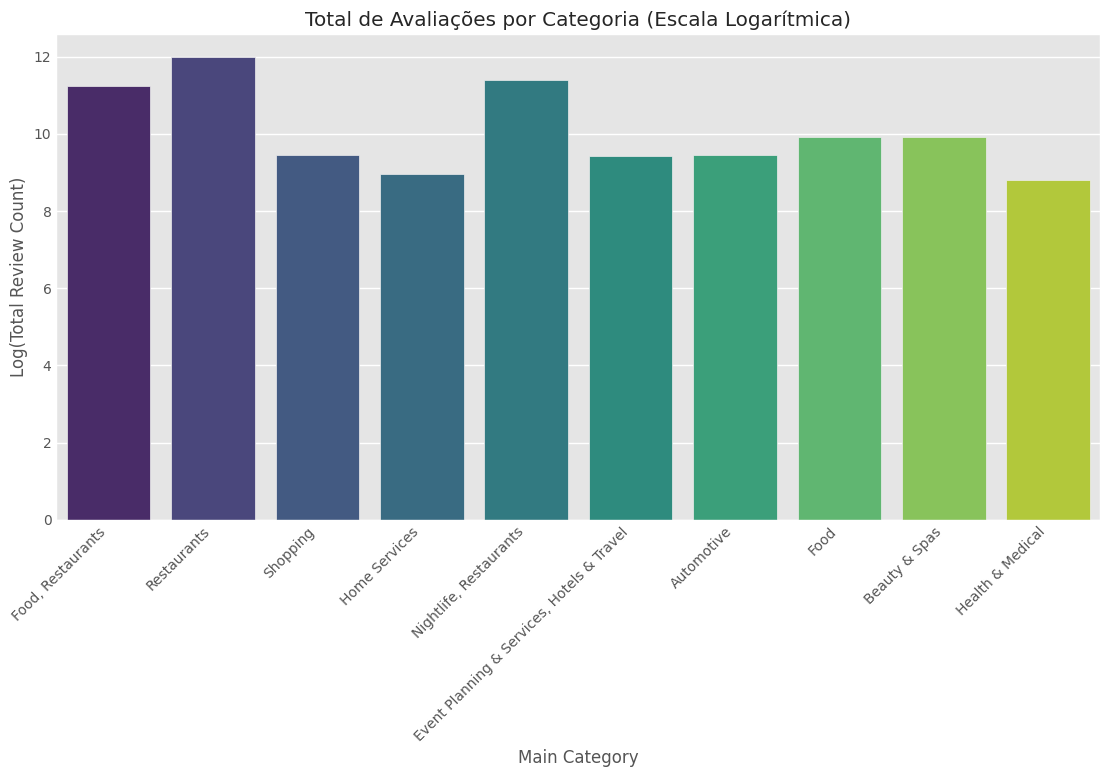

In [ ]:
# Gráfico de densidade para Review Count por Main Category (Escala Logarítmica)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_top_categories,
    x='main_category',
    y=np.log1p(df_top_categories.groupby('main_category')['review_count'].transform('sum')),
    palette='viridis'
)
plt.title('Total de Avaliações por Categoria (Escala Logarítmica)')
plt.xlabel('Main Category')
plt.ylabel('Log(Total Review Count)')
plt.xticks(rotation=45, ha="right")
plt.show()

Os resultados mostram que as categorias “Food, Restaurants”, “Restaurants” e “Nightlife, Restaurants” concentram o maior volume de avaliações. Esse comportamento sugere alto nível de engajamento dos usuários nesses segmentos, o que pode ser explorado pela empresa em estratégias de marketing, priorização de funcionalidades ou campanhas específicas. Da mesma forma, categorias com menor volume de avaliações podem representar oportunidades para ações voltadas ao aumento de engajamento.

**Pergunta 4: Quais palavras estão mais associadas a diferentes níveis de satisfação (estrelas)?**

/tmp/ipython-input-1773674933.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_star_words, x='Count', y='Word', palette='coolwarm')


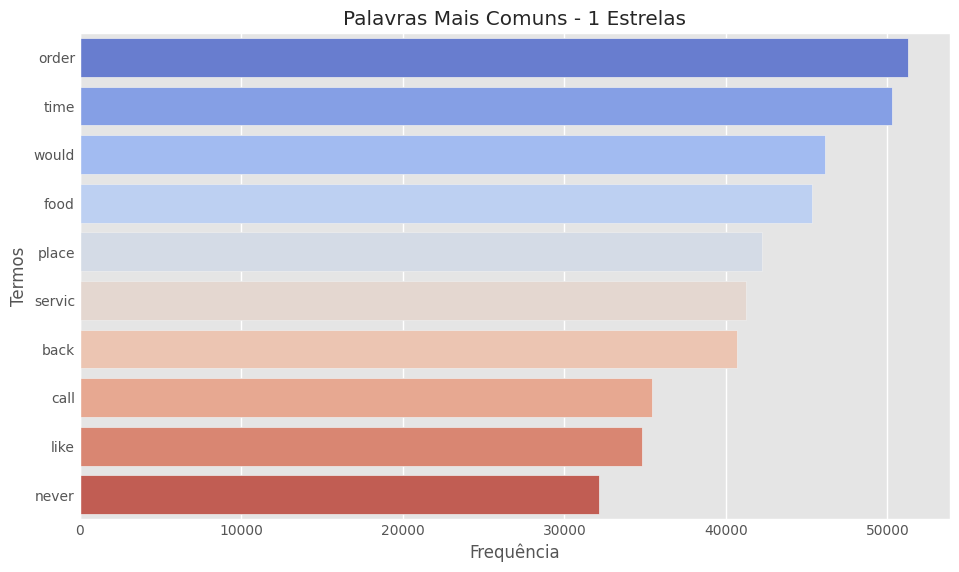

/tmp/ipython-input-1773674933.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_star_words, x='Count', y='Word', palette='coolwarm')


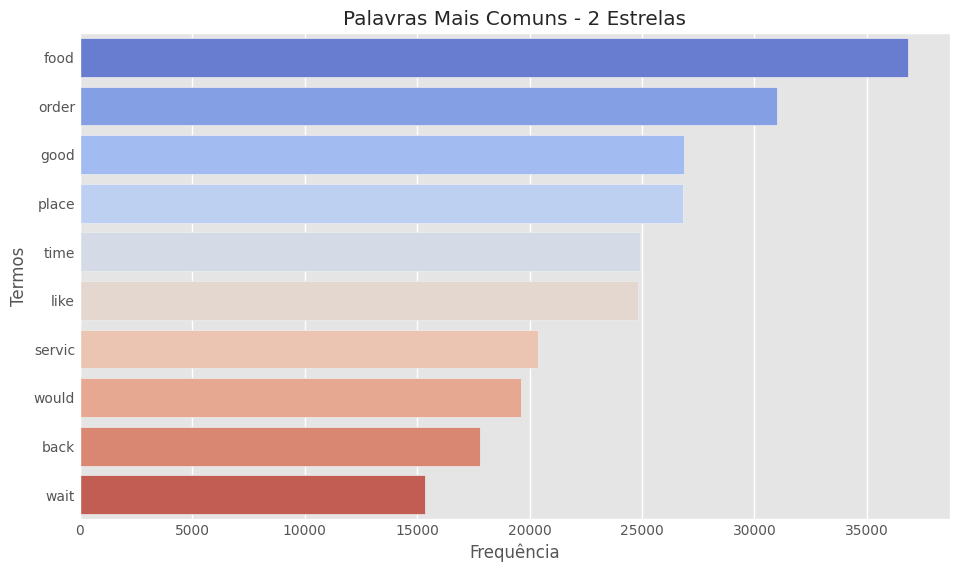

/tmp/ipython-input-1773674933.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_star_words, x='Count', y='Word', palette='coolwarm')


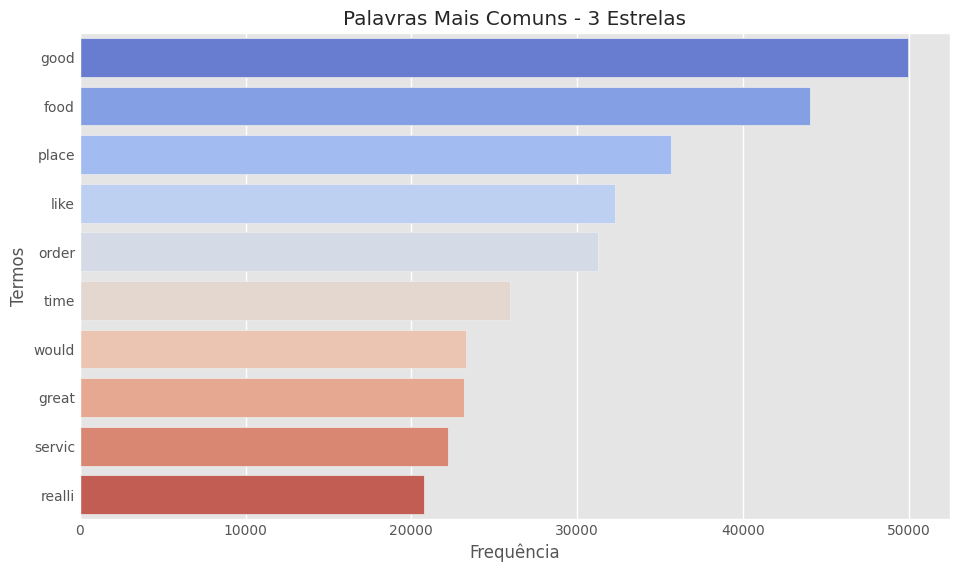

/tmp/ipython-input-1773674933.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_star_words, x='Count', y='Word', palette='coolwarm')


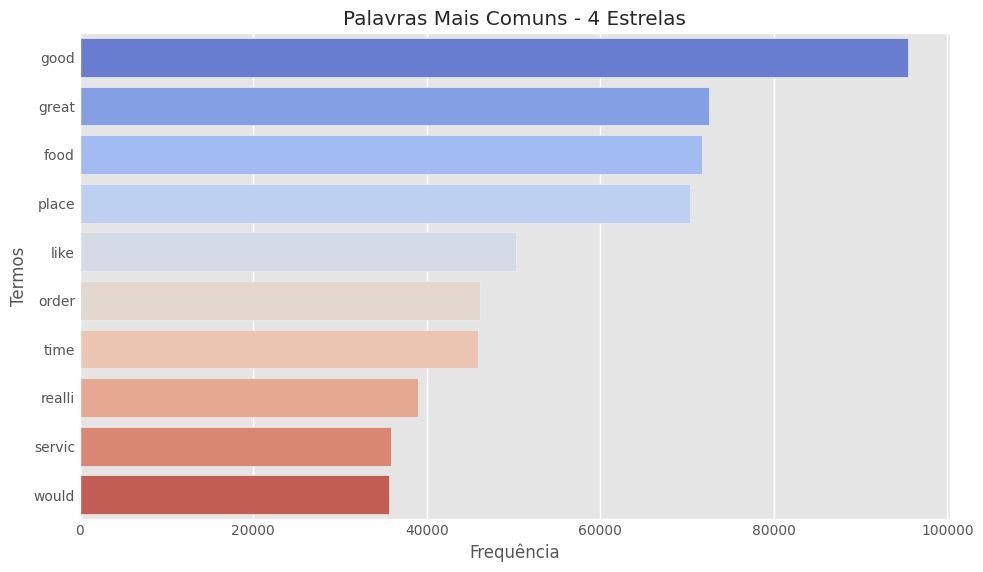

/tmp/ipython-input-1773674933.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_star_words, x='Count', y='Word', palette='coolwarm')


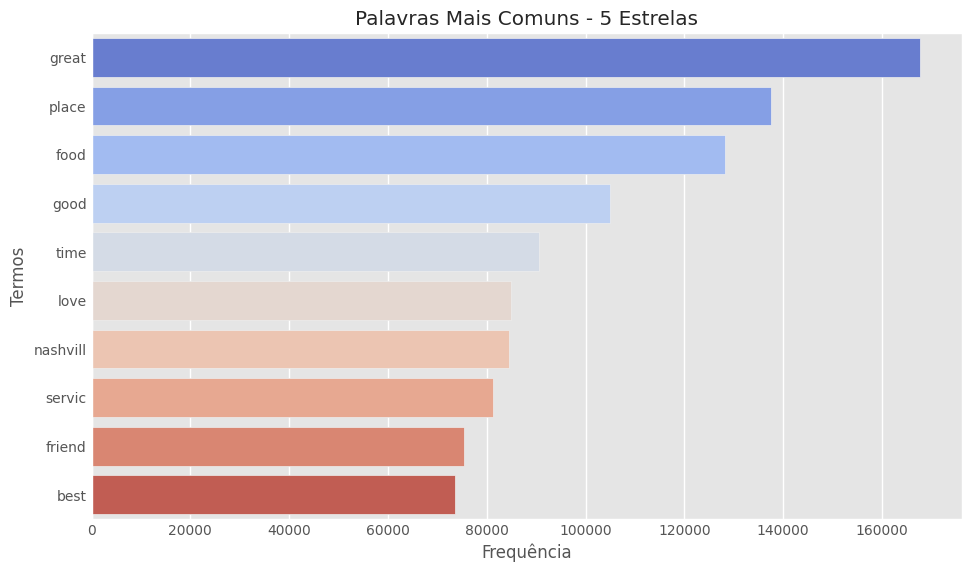

In [ ]:
# Definir o número de categorias de estrelas a serem analisadas
unique_stars = df_review['stars'].unique()

# Configurar um dicionário para armazenar as palavras mais comuns por estrelas
common_words_by_stars = {}

# Iterar pelas categorias de estrelas
for star in sorted(unique_stars):
    # Filtrar o DataFrame para a categoria de estrelas atual
    star_reviews = df_review[df_review['stars'] == star]['cleaned_text'].dropna()

    # Aplicar o CountVectorizer
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(star_reviews)

    # Somar as ocorrências de cada palavra
    word_counts = np.asarray(X.sum(axis=0)).flatten()
    word_freq = Counter(dict(zip(vectorizer.get_feature_names_out(), word_counts)))

    # Filtrar apenas palavras com mais de 3 letras
    filtered_word_freq = {word: count for word, count in word_freq.items() if len(word) > 3}

    # Selecionar as 10 palavras mais comuns para esta categoria de estrelas
    common_words_by_stars[star] = Counter(filtered_word_freq).most_common(10)

# Visualizar as palavras mais comuns por categoria de estrelas
for star, words in common_words_by_stars.items():
    df_star_words = pd.DataFrame(words, columns=['Word', 'Count'])
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_star_words, x='Count', y='Word', palette='coolwarm')
    plt.title(f'Palavras Mais Comuns - {star} Estrelas')
    plt.xlabel('Frequência')
    plt.ylabel('Termos')
    plt.show()

A análise de frequência de palavras por nível de avaliação indica que a maioria dos termos se repete ao longo dos diferentes níveis de estrelas, refletindo o vocabulário geral utilizado pelos usuários.

Uma exceção relevante é a palavra “never”, que aparece com maior frequência em avaliações de uma estrela, sugerindo sua associação a experiências negativas ou expectativas não atendidas. Esse tipo de termo pode ser particularmente útil em análises de sentimento e monitoramento de insatisfação dos clientes.

## 3.2 Análise Inferencial

Esta seção tem como objetivo aplicar testes estatísticos inferenciais para investigar relações entre variáveis, validar padrões observados na análise descritiva e extrair insights relevantes para o negócio. Os testes foram selecionados considerando as características dos dados, como distribuição, heterogeneidade de variâncias e tamanho das amostras.

In [ ]:
# Calcular a média geral do review_count
media_stars_geral = df_business['stars'].mean()

# Realizar o teste t para cada categoria
for categoria in top_10_categories:
    df_categoria = df_top_categories[df_top_categories['main_category'] == categoria]
    print(f"\nRealizando o teste t para a categoria: {categoria}")
    teste_t_uma_media(df_categoria, 'stars', media_stars_geral, alfa=0.05)


Realizando o teste t para a categoria: Restaurants
Teste t para uma Média:
Estatística t: -12.753878232545123
Valor p: 4.922972373136432e-36
Rejeita-se a hipótese nula. A média é significativamente diferente de 3.571499668214997.

Realizando o teste t para a categoria: Food, Restaurants
Teste t para uma Média:
Estatística t: 0.5961980166098714
Valor p: 0.5511881864149168
Não se rejeita a hipótese nula. A média não é significativamente diferente de 3.571499668214997.

Realizando o teste t para a categoria: Shopping
Teste t para uma Média:
Estatística t: 1.8471566392348076
Valor p: 0.06511812644861177
Não se rejeita a hipótese nula. A média não é significativamente diferente de 3.571499668214997.

Realizando o teste t para a categoria: Beauty & Spas
Teste t para uma Média:
Estatística t: 6.472836939633857
Valor p: 1.7573340112330734e-10
Rejeita-se a hipótese nula. A média é significativamente diferente de 3.571499668214997.

Realizando o teste t para a categoria: Automotive
Teste t para

**Diferenças de Avaliação entre Categorias de Negócio**

Foram realizados testes estatísticos para verificar se determinadas categorias de negócio apresentam médias de avaliações (stars) significativamente diferentes da média geral do dataset (3,571).

- Resultados com diferenças estatisticamente significativas:
  - Beauty & Spas
  - Food
  - Event Planning & Services
  - Hotels & Travel
  - Home Services
  - Restaurants

As categorias Beauty & Spas e Food apresentaram médias de stars significativamente superiores à média geral, indicando maior satisfação dos consumidores. Em contrapartida, categorias como Restaurants e Home Services apresentaram médias significativamente inferiores, sugerindo maior variabilidade ou desafios na percepção de qualidade por parte dos usuários.

- Resultados sem diferenças estatisticamente significativas:
  - Food, Restaurants
  - Nightlife, Restaurants
  - Health & Medical
  - Automotive

Essas categorias não apresentaram evidência estatística suficiente para afirmar que suas médias diferem da média geral, indicando avaliações mais próximas do padrão global da plataforma.

In [ ]:
# Definindo os grupos de avaliações positivas e negativas
grupo_positivo = df_business[df_business['stars'] >= 3.5]
grupo_negativo = df_business[df_business['stars'] < 3.5]

# Analisando a variável 'review-count'
print("Analisando a variável 'review-count':")
teste_levene(grupo_positivo, grupo_negativo, 'review_count', alfa=0.05)
teste_t_amostras_ind(grupo_positivo, grupo_negativo, 'review_count', alfa=0.05)

Analisando a variável 'review-count':
Teste de Levene:
Estatística de Teste: 123.41519184332576
Valor p: 1.5559787924500406e-28
Rejeita-se a hipótese nula, logo, não há homogeneidade de variâncias.
Teste t para Amostras Independentes:
Estatística t: 14.589020826930028
Valor p: 9.44692933742156e-48
Rejeita-se a hipótese nula, logo, há diferença significativa entre as médias nos grupos.


**Relação entre Avaliação Média (Stars) e Número de Avaliações (Review Count)**

Para investigar se estabelecimentos com avaliações positivas recebem mais engajamento, os dados foram divididos em dois grupos (avaliações positivas e negativas), utilizando a média de stars como critério inicial de separação.

O teste de Levene indicou ausência de homogeneidade de variâncias entre os grupos (p-value ≪ 0,05), sugerindo dispersões distintas no número de avaliações.

O teste t para amostras independentes apresentou p-value extremamente baixo, levando à rejeição da hipótese nula de igualdade de médias.

Esses resultados indicam que há diferença estatisticamente significativa no número médio de avaliações entre estabelecimentos com avaliações positivas e negativas, sugerindo que negócios melhor avaliados tendem a gerar maior engajamento dos usuários.

In [ ]:
# Definindo os grupos de avaliações positivas e negativas
grupo_positivo = df_review[df_review['stars'] >= 3.5]
grupo_negativo = df_review[df_review['stars'] < 3.5]

# Analisando a variável 'useful'
print("Analisando a variável 'useful':")
teste_levene(grupo_positivo, grupo_negativo, 'useful', alfa=0.05)
teste_t_amostras_ind(grupo_positivo, grupo_negativo, 'useful', alfa=0.05)

# Repetir para outras variáveis, como 'funny' e 'cool'
print("Analisando a variável 'funny':")
teste_levene(grupo_positivo, grupo_negativo, 'funny', 0.05)
teste_t_amostras_ind(grupo_positivo, grupo_negativo, 'funny', alfa=0.05)

print("Analisando a variável 'cool':")
teste_levene(grupo_positivo, grupo_negativo, 'cool', 0.05)
teste_t_amostras_ind(grupo_positivo, grupo_negativo, 'useful', alfa=0.05)

Analisando a variável 'useful':
Teste de Levene:
Estatística de Teste: 2074.854759188055
Valor p: 0.0
Rejeita-se a hipótese nula, logo, não há homogeneidade de variâncias.
Teste t para Amostras Independentes:
Estatística t: -39.35267288636405
Valor p: 0.0
Rejeita-se a hipótese nula, logo, há diferença significativa entre as médias nos grupos.
Analisando a variável 'funny':
Teste de Levene:
Estatística de Teste: 551.2661520157661
Valor p: 7.558185382109052e-122
Rejeita-se a hipótese nula, logo, não há homogeneidade de variâncias.
Teste t para Amostras Independentes:
Estatística t: -22.863242431515417
Valor p: 1.2957160619875003e-115
Rejeita-se a hipótese nula, logo, há diferença significativa entre as médias nos grupos.
Analisando a variável 'cool':
Teste de Levene:
Estatística de Teste: 2971.6362870756575
Valor p: 0.0
Rejeita-se a hipótese nula, logo, não há homogeneidade de variâncias.
Teste t para Amostras Independentes:
Estatística t: -39.35267288636405
Valor p: 0.0
Rejeita-se a hip

**Análise das Reações às Avaliações (Useful, Funny e Cool)**

Foram aplicados testes estatísticos para comparar as reações dos usuários às avaliações positivas e negativas.

- Principais resultados:
  - Para as três variáveis (useful, funny e cool), os testes indicaram:
    - Rejeição da hipótese de homogeneidade de variâncias;
    - Rejeição da hipótese de igualdade de médias entre os grupos.

As avaliações positivas apresentaram maior média e maior variabilidade nas reações, indicando que usuários tendem a interagir mais intensamente com avaliações de estabelecimentos bem avaliados. Esse comportamento sugere maior engajamento emocional e social quando a experiência é percebida de forma positiva.

**Definição do Threshold para Classificação de Sentimento**

Considerando a futura construção de um modelo de classificação de sentimento baseado no texto das avaliações, foi avaliada a adequação do limiar de 3,5 estrelas para separar avaliações positivas e negativas.

Como a variável stars não segue distribuição normal, foram utilizados intervalos de confiança para comparar as médias dos grupos. Os resultados mostraram que os intervalos não se sobrepõem, indicando uma separação clara entre os grupos.

Esse resultado valida o uso do threshold de 3,5 estrelas como um critério robusto para classificação, reduzindo ambiguidade entre classes e contribuindo para a qualidade do modelo supervisionado.

In [ ]:
# Separando os grupos de avaliações positivas e negativas
grupo_positivo = df_review[df_review['stars'] >= 3.5]['stars'].dropna().values
grupo_negativo = df_review[df_review['stars'] < 3.5]['stars'].dropna().values

intervalo_confianca(grupo_positivo, grupo_negativo)

Intervalo de Confiança a 95% para o grupo 'A': (np.float64(4.698941346284283), np.float64(4.70173754034165))
Intervalo de Confiança a 95% para o grupo 'B': (np.float64(1.8370707925425154), np.float64(1.844550218806941))


((np.float64(4.698941346284283), np.float64(4.70173754034165)),
 (np.float64(1.8370707925425154), np.float64(1.844550218806941)))

**Associação entre Stars e Review Count**

Testes de normalidade confirmaram que:
- stars não segue distribuição normal, o que é esperado para dados discretos e categóricos;
- review_count apresenta distribuição assimétrica à direita, com cauda longa.

Dado esse cenário, foi aplicado o teste de Kruskal-Wallis, que indicou diferenças estatisticamente significativas na distribuição de review_count entre diferentes níveis de stars. Isso sugere que determinados níveis de avaliação estão associados a maior ou menor volume de engajamento.

In [ ]:
# Teste de normalidade
teste_normalidade_shapirowilk(df_business, 'stars', alfa=0.05)

Teste de Normalidade Shapiro-Wilk:
Estatística do Teste: 0.9390377509826994
Valor p: 1.3689298084927356e-56
Rejeita-se a hipótese nula. A variável não segue uma distribuição normal.


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12056.
  res = hypotest_fun_out(*samples, **kwds)


(np.float64(0.9390377509826994), np.float64(1.3689298084927356e-56))

In [ ]:
# Teste de normalidade
teste_normalidade_shapirowilk(df_business, 'review_count', alfa=0.05)

Teste de Normalidade Shapiro-Wilk:
Estatística do Teste: 0.26592485182768544
Valor p: 1.9670600228669334e-112
Rejeita-se a hipótese nula. A variável não segue uma distribuição normal.


(np.float64(0.26592485182768544), np.float64(1.9670600228669334e-112))

In [ ]:
teste_kruskal_wallis(df_business, 'stars', 'review_count', alfa=0.05)

Teste Kruskal-Wallis:
Estatística do Teste: 844.08688521476
Valor p: 6.45464997559724e-177
Rejeita-se a hipótese nula. Há diferenças significativas entre os grupos.


(np.float64(844.08688521476), np.float64(6.45464997559724e-177))

Os resultados indicaram diferenças estatisticamente significativas entre os grupos, sugerindo que determinados níveis de avaliação estão associados a volumes distintos de engajamento. Em outras palavras, a quantidade de avaliações recebidas por um estabelecimento varia de forma sistemática conforme o nível de estrelas atribuído, reforçando a existência de uma relação entre percepção de qualidade e interação dos utilizadores.

**Seleção de Variáveis para Modelagem**

Por fim, foi aplicado o teste do qui-quadrado como estratégia de seleção de variáveis textuais, com o objetivo de reduzir a dimensionalidade e identificar termos mais relevantes para o modelo de classificação de sentimento. Os detalhes dessa etapa são aprofundados na notebook 'sentiment_analysus.ipynb'.

# 4. Conclusão

## Síntese da Análise

Este notebook teve como objetivo conduzir a Análise Exploratória e Inferencial dos dados de avaliações e estabelecimentos da plataforma Yelp, com foco em compreender padrões de comportamento dos consumidores, fatores associados à percepção de qualidade e ao engajamento dos usuários.

Ao longo da análise, foram realizadas:

- Exploração descritiva univariada e multivariada das tabelas Business e Review;

- Investigações estatísticas para validar hipóteses levantadas durante a EDA;

- Análises temporais, categóricas e textuais das avaliações;

- Testes inferenciais para avaliar diferenças entre categorias, níveis de avaliação e engajamento.

Essas etapas permitiram não apenas caracterizar o comportamento dos dados, mas também identificar relações estatisticamente significativas com implicações diretas para o negócio, além de embasar decisões metodológicas para as etapas posteriores do projeto, como clustering e classificação supervisionada.

## Impacto do Projeto e Recomendações Estratégicas

**1. Categorias com Avaliações Sistematicamente Mais Altas**

As categorias Beauty & Spas e Food apresentaram médias de estrelas consistentemente superiores à média geral da plataforma (3,5), com evidência estatística de diferença significativa.

Implicações para o negócio:

- Essas categorias podem ser priorizadas em campanhas de marketing, parcerias estratégicas e conteúdos de destaque dentro da plataforma.

- Os padrões de experiência do cliente nesses segmentos podem servir como benchmark para outros tipos de negócio com avaliações mais baixas.

**2. Relação entre Avaliação Média e Volume de Avaliações**

A análise indicou que o número de avaliações (review_count) não exerce influência significativa sobre a nota média (stars) atribuída aos estabelecimentos. A dispersão das estrelas se mantém relativamente estável independentemente do volume de reviews.

Implicações para o negócio:

- Estratégias focadas exclusivamente em aumentar o volume de avaliações tendem a ter impacto limitado na reputação média.

- A melhoria da experiência do cliente deve ser o principal foco para elevar avaliações, reforçando a importância da qualidade do serviço prestado.

**3. Categorias com Maior Engajamento dos Usuários**

As categorias Food, Restaurants e Nightlife concentram o maior volume de avaliações, evidenciando elevado engajamento dos usuários nesses segmentos.

Implicações para o negócio:

- Esses segmentos representam oportunidades estratégicas para ações de retenção, programas de fidelidade e funcionalidades voltadas ao engajamento.

- Categorias com menor volume de avaliações podem se beneficiar de campanhas direcionadas para estimular feedback e participação dos usuários.

**4. Engajamento e Reações às Avaliações**

As análises inferenciais mostraram que avaliações positivas recebem significativamente mais reações (useful, funny e cool), tanto em média quanto em variabilidade.

Implicações para o negócio:

- Avaliações positivas não apenas refletem satisfação, mas também geram maior interação social dentro da plataforma.

- O Yelp pode explorar esse comportamento para destacar avaliações de alto impacto ou incentivar usuários a compartilharem experiências positivas.

**5. Base Metodológica para Modelagem Supervisionada**

A análise inferencial validou o uso do threshold de 3,5 estrelas para a separação entre avaliações positivas e negativas, com intervalos de confiança não sobrepostos entre os grupos.

Implicações técnicas:

- Esse resultado fornece uma base estatística sólida para a construção do modelo de classificação de sentimento, reduzindo ambiguidade entre classes e aumentando a robustez do modelo supervisionado apresentado em notebook posterior.

## Próximos Passos e Possíveis Extensões do Projeto

Embora os objetivos deste notebook tenham sido alcançados, existem oportunidades relevantes de expansão e aprofundamento da análise:

**1. Exploração da Tabela Users**

Análise de perfis de utilizadores, padrões de engajamento e comportamento ao longo do tempo;

Identificação de usuários influentes ou altamente engajados.

**2. Uso da Coluna Attributes da Tabela Business**

Análise segmentada por categoria principal para extrair insights específicos (ex.: acessibilidade, métodos de pagamento, serviços adicionais);

Avaliação do impacto de atributos específicos na percepção de qualidade.